In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import linregress
import seaborn as sns
import pymc3 as pm
import arviz as az
import plot_helpers
import data_helpers
from data_helpers import gate_dataframe, canonical_data_frame
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import KMeans

In [2]:
PREGATED_DATA = os.path.exists('gated_positive_controls.csv')

# Loading the Positive Controls data

In [3]:
if PREGATED_DATA:
    # Shortcut
    df = pd.read_csv('gated_positive_controls.csv')

else:
    df = pd.read_csv('positive_controls.csv')
    df.index.set_names('Event')

In [4]:
df.set_index(['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event'], drop=True, inplace=True)

# Gate the Positive Control Data

In [5]:
if not PREGATED_DATA:
    df = gate_dataframe(df)

Input df index names are: ['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event']


/home/rpg/projects/xplan/replication-paper-data-analysis/data_helpers.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, 'xx_lab_id'] = new_df['lab_id']
/home/rpg/projects/xplan/replication-paper-data-analysis/data_helpers.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, 'xx_well'] = new_df['well']


Before groupby, new_df index names are: ['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event']
new_df2 columns are: Index(['od_cutoff', 'source_container', 'lab_id', 'id', 'gate', 'input',
       'filename', 'output', 'Time', 'FSC_A', 'SSC_A', 'BL1_A', 'RL1_A',
       'FSC_H', 'SSC_H', 'BL1_H', 'RL1_H', 'FSC_W', 'SSC_W', 'BL1_W', 'RL1_W',
       'index', 'live_no_stain', 'live', 'well', 'inc_time_1_hrs', 'xx_lab_id',
       'xx_well'],
      dtype='object')
new_df2 index levels are: ['lab_id', 'well', 'strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event']


In [11]:
duplicates = {x for x in df.index.names if x in df.columns}
df.drop(columns=list(duplicates), inplace=True)
print(duplicates)

{'plate_id', 'lab_id', 'event', 'od', 'well', 'inc_temp_degrees', 'media', 'replicate', 'inc_time_2_hrs', 'strain_name'}


# Remove data with 16h recovery time

There are not many of these -- only three plates -- and they were done with an earlier version of the protocol.  They also seem to have other oddities.

In [14]:
if not PREGATED_DATA:
    df.reset_index(inplace=True, drop=False)
    print('Experiments with 16h recovery time:')
    print(df[df['inc_time_1_hrs'] == 16].lab_id.unique())
    print('Experiments with 18h recovery time:')
    print(df[df['inc_time_1_hrs'] == 18].lab_id.unique())
    df = df[df['inc_time_1_hrs'] == 18]
else:
    assert df[df['inc_time_1_hrs'] == 16].empty

Experiments with 16h recovery time:
['r1c5va9wyf3mx_r1c63bjzu5ruy' 'r1c5vac658fxn_r1c66qw595ydy'
 'r1c5vad8u7ve2_r1c66q7cru28u']
Experiments with 18h recovery time:
['r1c7cpqp2k6cw_r1c7jn9syrr8s' 'r1c7cpu9nj2bu_r1c7fg23qkzph'
 'r1c7cpvfzqprk_r1c7fbvba55db' 'r1c84xvquwxth_r1c8ek7vcmdxh'
 'r1c84xwx57y95_r1c8ejz8jfg9z' 'r1c84xzc5dbuv_r1c8axrywctwb'
 'r1c84y3r9yqxb_r1c8auwvzbgt3' 'r1c8xx6qe9eea_r1c93enbf48t7'
 'r1c8xx7we38vw_r1c93cukfcxqp' 'r1c8xx94j94u7_r1c93ajvdzxz5'
 'r1c8yx25rrtag_r1c96v2w8x5pq' 'r1c8yydkumrkr_r1c96xsxw79c9'
 'r1c8yyg9gxbme_r1c96wn43pq45' 'r1c9tpmcezpk2_r1c9wjnedp92f'
 'r1cbajqru7kbe_r1cbe9p9zu6dh' 'r1cbuszfskzjt_r1cc6ws9c3dh4'
 'r1cbut2pdjtwv_r1cc6qzwcd4hx' 'r1cbut3veu2z4_r1cc6efukqtxx'
 'r1cckyeq9r358_r1ccqgmy5ffcd' 'r1cckyh56hjqj_r1ccpyjef2vca'
 'r1ccqfbz332u8_r1cctaf8r32rc' 'r1cctw6h5fsfg_r1ccx3axsj5ua'
 'r1cctw7qh3777_r1ccwxr4t3wb6' 'r1cdcerdbpda2_r1cdfphfehzq2'
 'r1cdcesknarkf_r1cdfg4x5uuwp' 'r1cdcetsvxgc2_r1cdfa6jrtssc'
 'r1cdfr4bjcnrg_r1cdnuqex83dm' 'r1cdfsf4ez

# Add logs for scatter values

In [15]:
if PREGATED_DATA:
    assert 'log_FSC_A' in df.columns
    assert 'log_SSC_A' in df.columns
else:
    df.loc[:, 'log_FSC_A'] = np.log10(df.FSC_A + 1)
    df.loc[:, 'log_SSC_A'] = np.log10(df.SSC_A + 1)

    # Drop bad log values

    rs = {
        'log_FSC_A': np.inf, 
        'log_FSC_A': -np.inf,
        'log_SSC_A': np.inf, 
        'log_SSC_A': -np.inf,
         }

    df = df.replace(to_replace=rs, value=np.nan)
    df.dropna(subset=['log_FSC_A', 'log_SSC_A'], inplace=True)

/tmp/ipykernel_41762/1550729792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'log_FSC_A'] = np.log10(df.FSC_A + 1)
/tmp/ipykernel_41762/1550729792.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'log_SSC_A'] = np.log10(df.SSC_A + 1)


Cache a copy of the data

In [16]:
if not PREGATED_DATA:
    df.to_csv('gated_positive_controls.csv')

# Clustering Ratios

In [17]:
df.loc[:, 'scatter_log_ratio'] = df['log_SSC_A'] / df['log_FSC_A']
df.loc[:, 'scatter_log_diff'] = df['log_SSC_A'] - df['log_FSC_A']

In [18]:
x = df['scatter_log_ratio'].values
x = np.reshape(x, (-1,1))
model = KMeans(n_clusters=2).fit(x)

In [19]:
df.loc[:, 'cluster_index'] = model.predict(x)

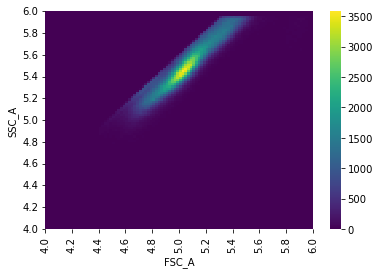

In [70]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 0], logscale=True), logscale=True);

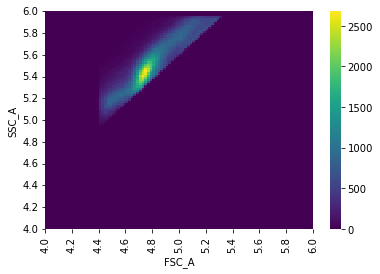

In [72]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 1], logscale=True), logscale=True);

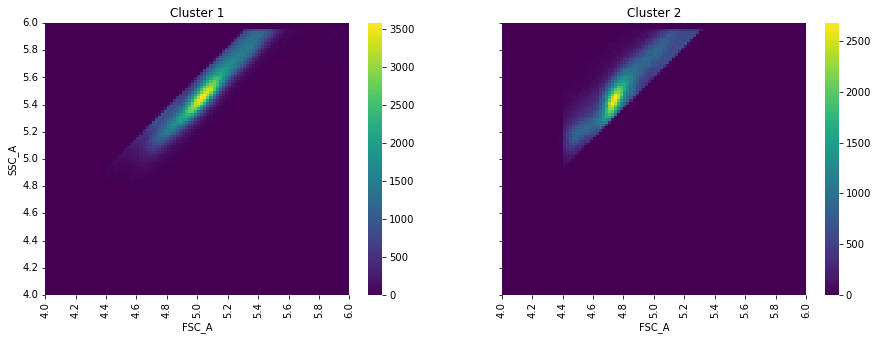

In [73]:
fig, axeses = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 0], logscale=True), 
                          logscale=True, 
                          ax=axeses[0] )
axeses[0].set_title('Cluster 1') ; axeses[1].set_title('Cluster 2')
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 1], logscale=True),
                          logscale=True,
                          ax=axeses[1])
axeses[1].set_ylabel("");
fig.savefig('two_cluster_positive_controls.pdf', format='pdf');

# Analyze the two clusters with linear regression

In [23]:
r_df = pd.DataFrame(columns=['r value', 'events'], index=pd.Index(['Cluster 1', 'Cluster 2', 'All Data']))

## Cluster 1

In [24]:
idf = df[df['cluster_index'] == 0]
lr_result = linregress(idf.log_FSC_A.values, idf.log_SSC_A.values)
r_df.at['Cluster 1', 'r value'] = lr_result.rvalue
r_df.at['Cluster 1', 'events'] = idf.shape[0]
lr_result

LinregressResult(slope=1.0147166061095962, intercept=0.36828888658172954, rvalue=0.9215660691152526, pvalue=0.0, stderr=0.00048263325942008356, intercept_stderr=0.002443024696819044)

## Cluster 2

In [25]:
idf = df[df['cluster_index'] == 1]
lr_result = linregress(idf.log_FSC_A.values, idf.log_SSC_A.values)
r_df.at['Cluster 2', 'r value'] = lr_result.rvalue
r_df.at['Cluster 2', 'events'] = idf.shape[0]
lr_result

LinregressResult(slope=1.0207795183079185, intercept=0.6326746073166243, rvalue=0.8979737198106874, pvalue=0.0, stderr=0.0007006031483456928, intercept_stderr=0.0033619011957189064)

## Pooled Data

In [26]:
idf = df
lr_result = linregress(idf.log_FSC_A.values, idf.log_SSC_A.values)
r_df.at['All Data', 'r value'] = lr_result.rvalue
r_df.at['All Data', 'events'] = idf.shape[0]
lr_result

LinregressResult(slope=0.7056139084969542, intercept=2.0151280864498013, rvalue=0.7444693938597196, pvalue=0.0, stderr=0.0005562450805791648, intercept_stderr=0.0027588797421526016)

## Comparison table

In [27]:
r_df

,r value,events
Cluster 1,0.921566,784445
Cluster 2,0.897974,509796
All Data,0.744469,1294241


In [28]:
r_df.to_latex('positive_controls_r_values.tex')

/tmp/ipykernel_41762/3693053959.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  r_df.to_latex('positive_controls_r_values.tex')


# Plot the fluorescence separately

In [93]:
reload(plot_helpers)
plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 0], channels=('FSC_A', 'BL1_A'), logscale=True).values.max()

4322

Automatic pdb calling has been turned OFF


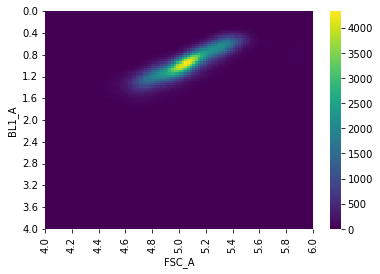

In [104]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 0], logscale=True, channels=('FSC_A', 'BL1_A')), logscale=True);

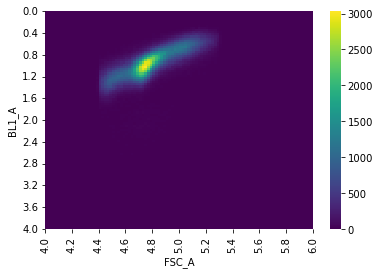

In [106]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df[df['cluster_index'] == 1], 
                                                                channels=('FSC_A', 'BL1_A'),
                                                                logscale=True), 
                          logscale=True);

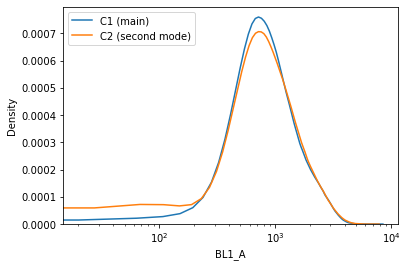

In [115]:
ax = sns.kdeplot(df[df['cluster_index'] == 0]['BL1_A'], label='C1 (main)')
sns.kdeplot(df[df['cluster_index'] == 1]['BL1_A'], ax=ax, label='C2 (second mode)')
ax.set_xscale('log')
ax.legend()
ax.figure.savefig('positive_control_clusters_fluorescence.pdf', format='pdf')